# Preliminary Steps
*   Connect to google drive to get data 
*   Install dependencies - SHAP library 

**NOTE : Edit data path** 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 13.4 MB/s 


In [5]:
data_path = '/content/drive/MyDrive/AGT_Mini_Project/data.csv'

# Import Required Libraries 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shutil

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import shap
from sklearn.inspection import permutation_importance

# Data Processing steps 

In [7]:
df = pd.read_csv(data_path)
display(df)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [8]:
# Drop id and Unnamed columns
df = df.drop(df.columns[[0, 32]], axis = 1)

# Convert diagnosis to binary - True/False predictions
df['diagnosis'] = df['diagnosis'] == 'M' # M -> malignant 

# For this project we use 10 features, that is just the mean value and discard the worst and standard error values 
df = df[['diagnosis','radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]

df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,True,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,True,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,True,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,True,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,True,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [9]:
# To check whether our dataset is imbalanced 

df.diagnosis.value_counts()

False    357
True     212
Name: diagnosis, dtype: int64

Since our Target Class that is 'Diagnosis' is somewhat imbalanced as number of False is not the same as number of True examples, we cannot totally rely on accuracy to judge our predictions. We need to perform more analysis by using confusion matrix, ROC curves etc. 

In [10]:
# Normalizing the data using z-score 

# copy the data
df_z_scaled = df.copy()
  
# apply normalization technique
for column in df_z_scaled.columns:
  if not column == 'diagnosis':
    df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / df_z_scaled[column].std()    
  
# view normalized data   
display(df_z_scaled)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,True,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764
1,True,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889
2,True,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658
3,True,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602
4,True,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956
...,...,...,...,...,...,...,...,...,...,...,...
564,True,2.109139,0.720838,2.058974,2.341795,1.040926,0.218868,1.945573,2.318924,-0.312314,-0.930209
565,True,1.703356,2.083301,1.614511,1.722326,0.102368,-0.017817,0.692434,1.262558,-0.217473,-1.057681
566,True,0.701667,2.043775,0.672084,0.577445,-0.839745,-0.038646,0.046547,0.105684,-0.808406,-0.894800
567,True,1.836725,2.334403,1.980781,1.733693,1.524426,3.269267,3.294046,2.656528,2.135315,1.042778


In [11]:
# Train-Test split 
data = df_z_scaled.drop('diagnosis', axis=1)
target = df_z_scaled['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.15)

# Model Building and Evaluation : Logistic Regression 

In [12]:
# Building Logistic Regression Model 
model_lr= LogisticRegression(max_iter=10000)
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)

# Print Accuracy of model 
model_lr.score(X_test, y_test)

0.9302325581395349

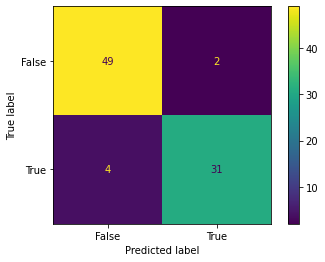

In [13]:
# Evaluating model by plotting confusion matrix 
plot_confusion_matrix(model_lr, X_test, y_test)  
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.988


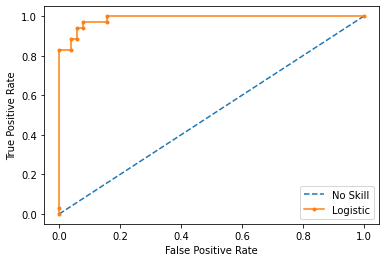

In [14]:
# Evaluating model by plotting ROC curves 

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = model_lr.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Model Building and Evaluation : Random Forest 

In [15]:
# Building Random Forest Model 

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
model_rf.score(X_test, y_test)

0.9186046511627907

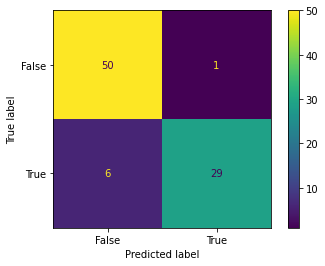

In [16]:
# Evaluating model by plotting confusion matrix 
plot_confusion_matrix(model_rf, X_test, y_test)  
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.985


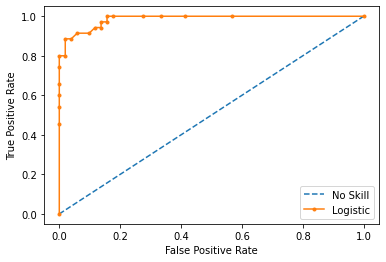

In [17]:
# Evaluating model by plotting ROC curves 

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = model_rf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Model Explainability

## Random Forest : Permutation Importance 



Text(0.5, 0, 'Permutation Importance')

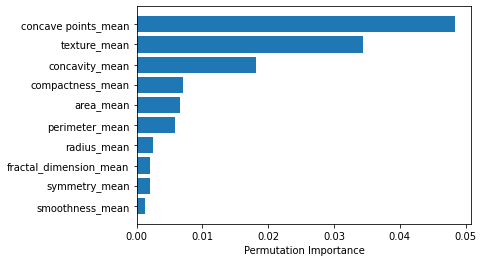

In [18]:
# Random forest
perm_importance = permutation_importance(model_rf, X_train, y_train)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Top 5 features for Random Forest : Concave points, Texture, Concavity, Area, Perimeter

## Logistic Regression : Permutation Importance 

Text(0.5, 0, 'Permutation Importance')

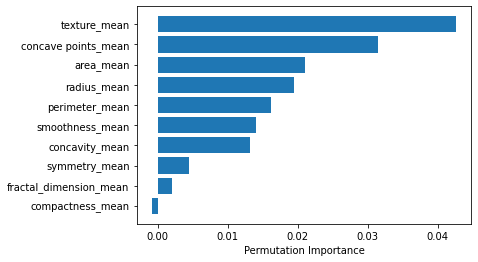

In [19]:
# Logistic Regression
perm_importance = permutation_importance(model_lr, X_train, y_train)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Top 5 features for Logistic Regression : Concave points, Concavity, Texture, Smoothness, Area

## Random Forest - SHAP

In [20]:
# Tree Explainer that can calculate SHAP values
explainer = shap.TreeExplainer(model_rf)
# Take a positive and negative sample instance i.e where diagnosis = True and False respectively
# y_test.iloc[0] = 'True', y_test.iloc[1] = 'False'
positive_instance = X_test.iloc[0] 
positive_class = y_test.iloc[0]
negative_instance = X_test.iloc[1] 
negative_class = y_test.iloc[1]

In [21]:
# Prediction for positive sample
print(f"Model prediction for positive sample = {model_rf.predict_proba(positive_instance.values.reshape(1,-1))}")

# Prediction for negative sample
print(f"Model prediction for negative sample = {model_rf.predict_proba(negative_instance.values.reshape(1,-1))}")

# Get Shapley values for the positive instance
shap_values_positive = explainer.shap_values(positive_instance)

# Get Shapley values for the negative instance
shap_values_negative = explainer.shap_values(negative_instance)

print(f"Shap Values for positive instance = {shap_values_positive[1]}")

print(f"Shap Values for negative instance = {shap_values_negative[1]}")

Model prediction for positive sample = [[0.96 0.04]]
Model prediction for negative sample = [[0.34 0.66]]
Shap Values for positive instance = [-0.03721578 -0.07796253  0.02514945 -0.04399202 -0.01203211 -0.00103846
 -0.06833861 -0.11060999 -0.00516633  0.00886682]
Shap Values for negative instance = [-0.02774941  0.03195537  0.05490381 -0.0383281  -0.04625225  0.02983452
  0.10849602  0.21137383 -0.0277475   0.00117416]


In [22]:
# Positive Instance Force Plot
shap_values = explainer.shap_values(positive_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], positive_instance)

In [23]:
# Negative Instance Force Plot
shap_values = explainer.shap_values(negative_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], negative_instance)

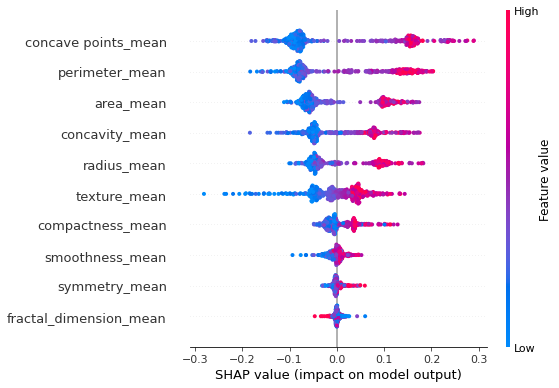

In [24]:
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train)

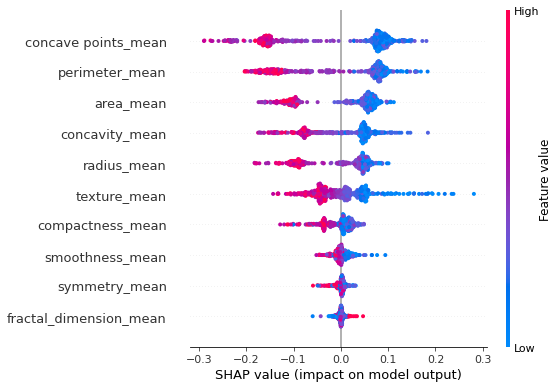

In [25]:
shap.summary_plot(shap_values[0], X_train)

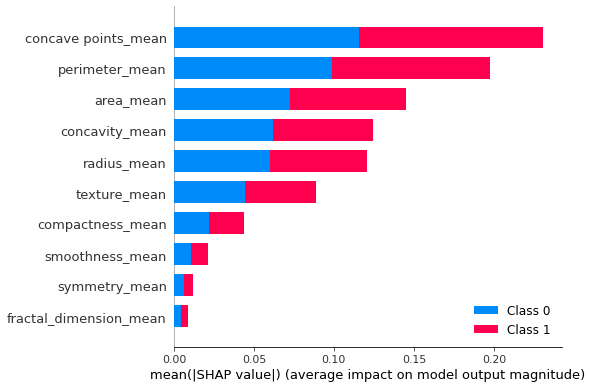

In [26]:
shap.summary_plot(shap_values, X_train)

## Logistic Regression - SHAP

In [41]:
# Linear Explainer that can calculate SHAP values
explainer = shap.LinearExplainer(model_lr, X_train)
# Take a positive and negative sample instance i.e where diagnosis = True and False respectively
# y_test.iloc[-1] = 'True', y_test.iloc[0] = 'False'
positive_instance = X_test.iloc[-1] 
positive_class = y_test.iloc[-1]
negative_instance = X_test.iloc[0] 
negative_class = y_test.iloc[0]

In [42]:
# Prediction for positive sample
print(f"Model prediction for positive sample = {model_rf.predict_proba(positive_instance.values.reshape(1,-1))}")

# Prediction for negative sample
print(f"Model prediction for negative sample = {model_rf.predict_proba(negative_instance.values.reshape(1,-1))}")


Model prediction for positive sample = [[0. 1.]]
Model prediction for negative sample = [[0.96 0.04]]


In [43]:
# Positive Instance Force Plot
shap_values = explainer.shap_values(positive_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, positive_instance)

In [44]:
# Negative Instance Force Plot
shap_values = explainer.shap_values(negative_instance)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, negative_instance)

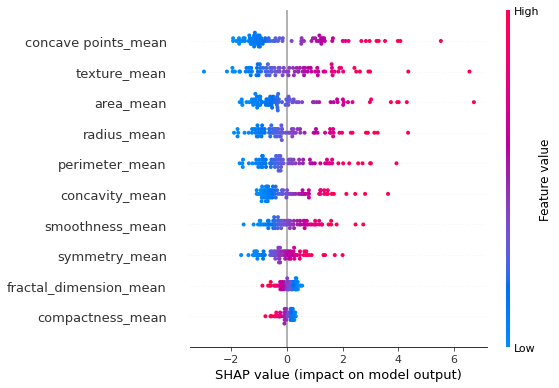

In [46]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
